## Context - Taken from Kaggle
Did you know that claims can be filed against TSA? Sometimes US Terminal Security Agency (TSA) makes mistakes. People can get hurt and property can be damaged, lost, or stolen. Claims are generally filed against TSA for personal injuries and lost or damaged property during screenings and they keep records of every claim!

### Content
The dataset includes claims filed between 2002 through 2015.

1. Claim Number
1. Date Received
1. Incident Date
1. Airport Code
1. Airport Name
1. Airline Name
1. Claim Type
1. Claim Site
1. Item
1. Claim Amount
1. Status
1. Close Amount
1. Disposition

This data is coming from the Kaggle Dataset that contain the data of clain the been filed into the TSA. We would try to explore the data and clean the data partially (we would not clean and analyze everything as it would take more time than necessary) and we would only use 25% data from the original dataset.


Try to read the data and show all the important info first. For starter, try to understand what each column represent.

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import welch_anova, pairwise_gameshowell, pairwise_ttests, anova
from scipy.stats import chi2,ttest_ind, mannwhitneyu, levene,bartlett, f_oneway,kruskal, shapiro, anderson, normaltest, chisquare

%matplotlib inline

## Functions

In [2]:
def nullity(data):
    df=pd.DataFrame(columns=['dataFeatures','dataType','null','nullPct','unique','uniqueSample'])
    df['dataFeatures']=data.columns
    df['dataType']=[i for i in data.dtypes]
    df['null']=df['dataFeatures'].apply(lambda x: sum(data[x].isna()))
    df['nullPct']=df['null'].apply(lambda x: round((x/len(data))*100,2))
    df['unique']=df['dataFeatures'].apply(lambda x: len(data[~(data[x].isna())][x].unique()))
    df['uniqueSample']=df['dataFeatures'].apply(lambda x: data[x].drop_duplicates().sample(2).values)
    return df

In [3]:
def try_normal(data):
    result = {'Anderson' : {i:j for i,j in zip(anderson(data)[2], anderson(data)[1])}, 'Shapiro': shapiro(data)[1], 
     'K^2': normaltest(data)[1]}
    result['Anderson']['stat'] = anderson(data)[0]
    return result

In [4]:
def create_qqplot(data,title):
    sm.qqplot(data, line = '45')
    plt.title(title)
    pylab.show()

In [5]:
def try_equal_var(x1,x2):
    result = {'Bartlett': {'Bartlett-Stat' : bartlett(x1,x2)[0], 'P-Value': bartlett(x1,x2)[1] },
             'Levene': {'Levene-Stat': levene(x1,x2)[0], 'P-Value': levene(x1,x2)[1]}}
    return result

In [6]:
tsa=pd.read_csv('tsa_claims_ujian.csv')

In [7]:
tsa.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
1,14268,20-Jun-02,6/16/2002 0:00,PHX,Phoenix Sky Harbor International,NaN,Property Damage,Checkpoint,Computer - Laptop,$2;270.09,Canceled,NaN,NaN
2,15242,12-Jul-02,5/31/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Other,Luggage (all types including footlockers),$200.00,Denied,$0.00,Deny
3,16759,21-Aug-02,7/12/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,Passenger Property Loss,Checkpoint,Other,$21.44,Approved,$21.00,Approve in Full
4,17846,9-Sep-02,8/30/2002 0:00,BOS,Boston (Logan) International Airport,NaN,Property Damage,Checkpoint,Luggage (all types including footlockers),$1;832.22,Canceled,$0.00,NaN


In [8]:
tsa[(tsa['Disposition'].isna()) & (tsa['Close Amount'].isna()) & (tsa['Airport Code']=='-') & (tsa['Airport Name']=='-')].head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
36268,2010011967631,19-Jan-10,1/19/2010 0:00,-,-,-,Personal Injury,Checkpoint,Cosmetics & Grooming; Jewelry & Watches; Perso...,-,-,NaN,NaN
36373,2010020468312,4-Feb-10,2/4/2010 0:00,-,-,-,-,-,-,-,-,NaN,NaN
36374,2010021368379,4-Feb-10,1/2/2010 0:00,-,-,USAir,-,-,-,-,-,NaN,NaN
36557,2010030969294,5-Mar-10,1/3/2010 0:00,-,-,-,-,-,-,-,-,NaN,NaN
36827,2010041270684,9-Apr-10,4/7/2010 0:00,-,-,-,-,-,Clothing,-,-,NaN,NaN


In [9]:
tsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51066 entries, 0 to 51065
Data columns (total 13 columns):
Claim Number     51066 non-null object
Date Received    50996 non-null object
Incident Date    50496 non-null object
Airport Code     49014 non-null object
Airport Name     49014 non-null object
Airline Name     42511 non-null object
Claim Type       49106 non-null object
Claim Site       50876 non-null object
Item             50054 non-null object
Claim Amount     50074 non-null object
Status           51065 non-null object
Close Amount     33786 non-null object
Disposition      32846 non-null object
dtypes: object(13)
memory usage: 5.1+ MB


In [10]:
tsa.describe()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
count,51066,50996,50496,49014,49014,42511,49106,50876,50054,50074,51065,33786,32846
unique,51065,3522,10788,405,419,243,8,6,1854,13248,13,6009,3
top,2013121110011,27-May-04,12/22/2004 0:00,LAX,John F. Kennedy International,American Airlines,Passenger Property Loss,Checked Baggage,Other,$0.00,Denied,$0.00,Deny
freq,2,182,43,2379,2286,4377,29713,39937,9183,7065,17134,17907,17147


In [11]:
null=nullity(tsa)
null

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Claim Number,object,0,0.00,51065,"[2006091112321, 2006090111924]"
1,Date Received,object,70,0.14,3522,"[16-Nov-05, 21-Jul-04]"
2,Incident Date,object,570,1.12,10788,"[10/12/2010 17:30, 7/9/2008 0:00]"
3,Airport Code,object,2052,4.02,405,"[ABY, MDT]"
4,Airport Name,object,2052,4.02,419,"[Plattsburgh International Aiport, Durango - L..."
5,Airline Name,object,8555,16.75,243,"[Condor Air, Egypt Air]"
6,Claim Type,object,1960,3.84,8,"[Employee Loss (MPCECA), Complaint]"
7,Claim Site,object,190,0.37,6,"[nan, Bus Station]"
8,Item,object,1012,1.98,1854,[Alcoholic beverages; Books - Fiction; paperba...
9,Claim Amount,object,992,1.94,13248,"[$83.26 , $351.00 ]"


If you notice, there is '-' value that become a filler for an empty value. Replace all these '-' in every column into NaN object (np.nan) 

In [12]:
def transform(col):
    if col=='-':
        return np.nan
    else:
        return col
def date(col):
    try:
        return pd.to_datetime(col)
    except:
        return col

In [13]:
for i in tsa.columns:
    tsa[i]=tsa[i].apply(transform)

Try to convert the Date Received and Incident Date data type into Datetime object. For the Incident Date columns, if you directly try to convert the column into datetime object it would raise an error notice. In that case, try to show the dataframe with the Incident Date column contain all the error.  

In [14]:
tsa['Date Received']=pd.to_datetime(tsa['Date Received'])

In [15]:
tsa['Incident Date']=tsa['Incident Date'].apply(date)

In [16]:
idx_error=[]
idx=0
for i in tsa['Incident Date']:
    if type(i)==str:
        idx_error.append(idx)
    idx+=1
tsa.loc[idx_error]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
13729,2005021676300,2005-01-24,17-MAY-0200 00:00,JFK,John F. Kennedy International,NaN,Passenger Property Loss,Checkpoint,Other,$15.00,Approved,$15.00,Approve in Full
14323,2005031778682,2005-02-23,17-FEB-0205 00:00,MSY,New Orleans International,UAL,Passenger Property Loss,Checked Baggage,Computer - Laptop,$2;463.00,Denied,NaN,Deny
14856,2005033180821,2005-03-23,07-MAR-0005 00:00,CVG,Cincinnati/Northern Kentucky International,Delta Air Lines,Passenger Property Loss,Checked Baggage,Cameras - Digital,$430.98,Approved,$430.98,Approve in Full
14976,2005040181143,2005-03-29,04-MAR-0205 00:00,MSP,Minneapolis/ St.Paul International Airport,Northwest Airlines,Passenger Property Loss,Checked Baggage,Jewelry - Fine,$151.00,Insufficient; one of the following items requi...,NaN,NaN
14995,2005040581540,2005-03-30,18-MAR-0200 00:00,MAF,Midland International Airport,Continental Express Inc,Passenger Property Loss,Checked Baggage,Locks,$10.60,Approved,$10.60,Approve in Full
15278,2005041282328,2005-04-12,12-MAR-0205 00:00,MSP,Minneapolis/ St.Paul International Airport,Northwest Airlines,Property Damage,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,$710.00,Denied,$0.00,Deny
15934,2005051985030,2005-05-17,01-MAY-0205 00:00,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,Jewelry - Fine,$197.73,Insufficient; one of the following items requi...,NaN,NaN
16813,2005071188622,2005-07-08,01-JUL-0200 00:00,HDN,Yampa Valley Regional,NaN,Passenger Property Loss,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,$300.00,Denied,$0.00,Deny
17198,2005091492472,2005-08-01,01-MAY-0205 00:00,IAH,Houston - George Bush Intercontinental Airport,UAL,Passenger Property Loss,Checked Baggage,Other,$2;000.72,Denied,$0.00,Deny
19151,2005121397614,2005-12-08,20-NOV-0205 00:00,LNK,Lincoln Municipal,Northwest Airlines,Passenger Property Loss,Checked Baggage,Locks,$15.00,Approved,$15.00,Approve in Full


For the data in the Incident Date column that contain error, replace the year with the year that come from the Date Received column and replace the Incident Date data type into datetime object

In [17]:
for i in idx_error:
    isi=tsa['Incident Date'][i]
    thn=isi[7:11]
    tsa['Incident Date'][i]=isi.replace(thn,str(tsa.loc[i]['Date Received'].year))

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
tsa['Incident Date']=pd.to_datetime(tsa['Incident Date'])

Check the data info and the dataframe that previously contain the error in their data to see if the data have been properly corrected.

In [19]:
tsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51066 entries, 0 to 51065
Data columns (total 13 columns):
Claim Number     51066 non-null object
Date Received    50996 non-null datetime64[ns]
Incident Date    50496 non-null datetime64[ns]
Airport Code     48915 non-null object
Airport Name     48915 non-null object
Airline Name     41470 non-null object
Claim Type       49035 non-null object
Claim Site       50817 non-null object
Item             48918 non-null object
Claim Amount     46886 non-null object
Status           47877 non-null object
Close Amount     33786 non-null object
Disposition      32846 non-null object
dtypes: datetime64[ns](2), object(11)
memory usage: 5.1+ MB


In [20]:
tsa.loc[idx_error]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
13729,2005021676300,2005-01-24,2005-05-17,JFK,John F. Kennedy International,NaN,Passenger Property Loss,Checkpoint,Other,$15.00,Approved,$15.00,Approve in Full
14323,2005031778682,2005-02-23,2005-02-17,MSY,New Orleans International,UAL,Passenger Property Loss,Checked Baggage,Computer - Laptop,$2;463.00,Denied,NaN,Deny
14856,2005033180821,2005-03-23,2005-03-07,CVG,Cincinnati/Northern Kentucky International,Delta Air Lines,Passenger Property Loss,Checked Baggage,Cameras - Digital,$430.98,Approved,$430.98,Approve in Full
14976,2005040181143,2005-03-29,2005-03-04,MSP,Minneapolis/ St.Paul International Airport,Northwest Airlines,Passenger Property Loss,Checked Baggage,Jewelry - Fine,$151.00,Insufficient; one of the following items requi...,NaN,NaN
14995,2005040581540,2005-03-30,2005-03-18,MAF,Midland International Airport,Continental Express Inc,Passenger Property Loss,Checked Baggage,Locks,$10.60,Approved,$10.60,Approve in Full
15278,2005041282328,2005-04-12,2005-03-12,MSP,Minneapolis/ St.Paul International Airport,Northwest Airlines,Property Damage,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,$710.00,Denied,$0.00,Deny
15934,2005051985030,2005-05-17,2005-05-01,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,Jewelry - Fine,$197.73,Insufficient; one of the following items requi...,NaN,NaN
16813,2005071188622,2005-07-08,2005-07-01,HDN,Yampa Valley Regional,NaN,Passenger Property Loss,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,$300.00,Denied,$0.00,Deny
17198,2005091492472,2005-08-01,2005-05-01,IAH,Houston - George Bush Intercontinental Airport,UAL,Passenger Property Loss,Checked Baggage,Other,$2;000.72,Denied,$0.00,Deny
19151,2005121397614,2005-12-08,2005-11-20,LNK,Lincoln Municipal,Northwest Airlines,Passenger Property Loss,Checked Baggage,Locks,$15.00,Approved,$15.00,Approve in Full


Create a new feature of the day differences between claim received and the day of the incident called Day Differences, which contain the days that come from the Date Received column substracted by the Incident Date column (Date Received - Incident Date). We have this feature to see the time differences between when the claim made with the incident that happen.

In [21]:
tsa['Day Differences']=(tsa['Date Received']-tsa['Incident Date'])

In [22]:
tsa['Day Differences']=tsa['Day Differences'].apply(lambda x: x.days)

Lets try to visualize the distribution of the Day Differences with all the NaN just to be dropped first

In [23]:
tsa_nonull=tsa[~(tsa['Day Differences'].isna())]

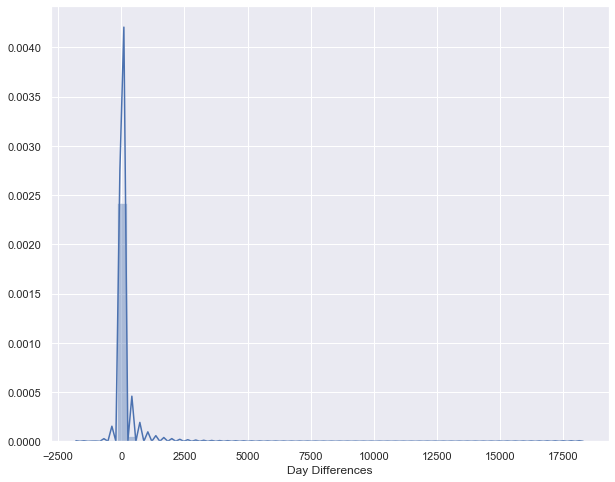

In [24]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.distplot(tsa_nonull['Day Differences'])

If we seen it from the plot, it seems there is days that less than 0 and even over than 1000. Lets try to visualize them both

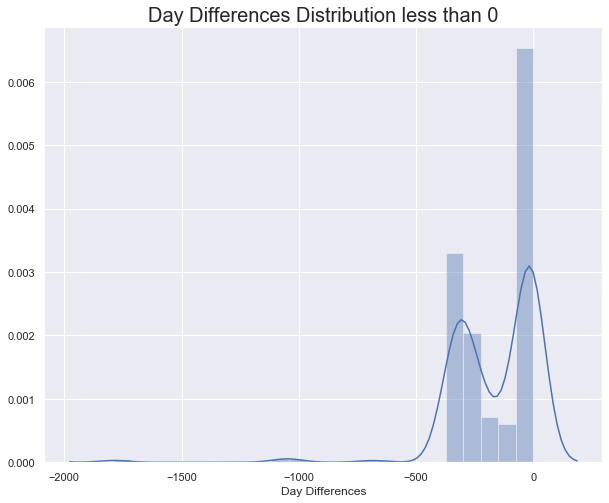

In [58]:
plt.figure(figsize=(10,8))
plt.title('Day Differences Distribution less than 0', fontsize=20)
sns.distplot(tsa_nonull[(tsa_nonull['Day Differences']<0)]['Day Differences'])

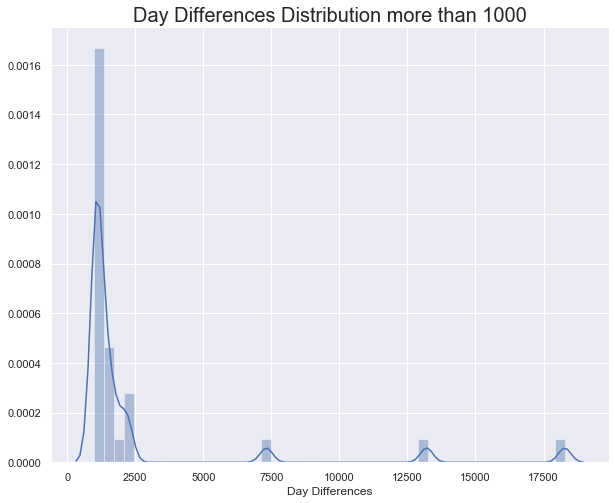

In [59]:
plt.figure(figsize=(10,8))
plt.title('Day Differences Distribution more than 1000', fontsize=20)
sns.distplot(tsa_nonull[(tsa_nonull['Day Differences']>1000)]['Day Differences'])

In [27]:
tsa_below_zero=tsa_nonull[tsa_nonull['Day Differences']<0]
tsa_over_thousand=tsa_nonull[tsa_nonull['Day Differences']>1000]

In [28]:
for i in tsa_below_zero.columns:
    print(i)
    print(tsa_below_zero[i].value_counts())
    print('\n')

Claim Number
2004052453211    1
2008021939773    1
2004122771081    1
0223267M         1
2006082111337    1
                ..
2005012874795    1
2009031256148    1
2006063008809    1
2011011379541    1
0223260M         1
Name: Claim Number, Length: 448, dtype: int64


Date Received
2004-03-18    6
2005-02-03    5
2005-02-01    5
2004-09-12    5
2004-08-01    4
             ..
2004-08-05    1
2003-05-15    1
2006-10-17    1
2004-05-04    1
2005-06-01    1
Name: Date Received, Length: 339, dtype: int64


Incident Date
2005-12-24 00:00:00    4
2004-11-16 00:00:00    3
2005-12-28 00:00:00    3
2004-08-27 00:00:00    3
2007-12-17 00:00:00    3
                      ..
2012-07-16 06:00:00    1
2010-08-24 04:00:00    1
2010-06-22 00:00:00    1
2004-06-04 00:00:00    1
2011-05-19 00:00:00    1
Name: Incident Date, Length: 380, dtype: int64


Airport Code
LAX    23
EWR    21
MIA    19
ORD    19
PHX    18
       ..
GSP     1
PWM     1
TLH     1
GRR     1
ISP     1
Name: Airport Code, Length: 11

In [29]:
a=tsa.loc[idx_error]
a[a['Day Differences']<0]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,Day Differences
13729,2005021676300,2005-01-24,2005-05-17,JFK,John F. Kennedy International,NaN,Passenger Property Loss,Checkpoint,Other,$15.00,Approved,$15.00,Approve in Full,-113.0
22161,2006072610104,2006-07-14,2006-10-25,MEM,Memphis International Airport,Northwest Airlines,Passenger Property Loss,Checked Baggage,Cell Phones,$35.00,Denied,$0.00,Deny,-103.0
24355,2007010418246,2007-01-03,2007-11-03,OMA,Eppley Airfield,Skywest Airlines Inc USA,Passenger Property Loss,Checked Baggage,Jewelry - Costume,$135.00,Denied,$0.00,Deny,-304.0
24525,2007011718892,2007-01-10,2007-08-12,JFK,John F. Kennedy International,Jet Blue,Passenger Property Loss,Checked Baggage,Video Recordings (blank & commercial),$317.64,Settled,$158.82,Settle,-214.0
24768,2007013119947,2007-01-26,2007-12-19,PHX,Phoenix Sky Harbor International,Northwest Airlines,Property Damage,Checked Baggage,Other,$90.00,Denied,$0.00,Deny,-327.0
29065,2008011437819,2008-01-07,2008-11-30,RAP,Rapid City Regional,Northwest Airlines,Passenger Property Loss,Checked Baggage,Clothing - Shoes; belts; accessories; etc.; Lu...,$200.00,Denied,$0.00,Deny,-328.0


In [30]:
for i in tsa_over_thousand.columns:
    print(i)
    print(tsa_over_thousand[i].value_counts())
    print('\n')

Claim Number
2008011838197    1
2008091249804    1
2008080648074    1
2015052122662    1
2005021175960    1
2005081290465    1
2006041004307    1
2004082761476    1
2005113096722    1
2005051985108    1
2008110651978    1
1217135M         1
2006062608536    1
2007012919703    1
2005071188547    1
2006042505316    1
0305106M         1
2005061086208    1
2008030640547    1
0212302M         1
2004100464331    1
2004082661422    1
2005112396390    1
2006111415554    1
2007102634000    1
2005032579905    1
2016010528111    1
2004092763903    1
0212087M         1
2009121666582    1
Name: Claim Number, dtype: int64


Date Received
2006-04-13    1
2006-03-30    1
2007-12-19    1
2008-03-09    1
2004-02-12    1
2007-01-24    1
2007-10-05    1
2025-08-02    1
2008-01-14    1
2008-07-06    1
2007-10-22    1
2008-02-26    1
2003-12-17    1
2007-01-07    1
2005-11-10    1
2015-05-21    1
2004-07-19    1
2009-12-01    1
2006-06-23    1
2004-03-05    1
2008-10-31    1
2007-08-27    1
2007-07-27    1


Day Differences kurang dari 0:
Dilihat dari value counts untuk setiap kolom pada dataframe yang memiliki nilai day difference kurang dari 0, tidak terdapat hal yang signifikan yang menyebabkan day difference kurang dari 0. Kemungkinan day differencenya kurang dari nol dikarenakan transformasi tanggal yang dilakukan yang mengubah tahun dengan tahun received date. Namun jumlah day difference kurang dari 0 ketika ditransformasikan tahun dari incident date hanya 6. Sehingga, saya berasumsi bahwa data-data yang memiliki day difference kurang dari 0 itu dikarenakan kelalaian petugas TSA menginput data.

Day Differences lebih dari 1000:


Remove the $ sign (some data need even more clean up by replacing the ; sign into . sign) from the Claim Amount columns and Close Amount columns, and change those columns datatype into float datatype

In [31]:
tsa['Close Amount']=tsa['Close Amount'].apply(lambda x: float(str(x).replace('$','').replace(';','')))
tsa['Claim Amount']=tsa['Claim Amount'].apply(lambda x: float(str(x).replace('$','').replace(';','')))

In [32]:
tsa['Amount Differences']=tsa['Claim Amount']-tsa['Close Amount']

Create a new columns called Amount Differences by substract the Claim Amount with Close Amount columns

In [33]:
tsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51066 entries, 0 to 51065
Data columns (total 15 columns):
Claim Number          51066 non-null object
Date Received         50996 non-null datetime64[ns]
Incident Date         50496 non-null datetime64[ns]
Airport Code          48915 non-null object
Airport Name          48915 non-null object
Airline Name          41470 non-null object
Claim Type            49035 non-null object
Claim Site            50817 non-null object
Item                  48918 non-null object
Claim Amount          46886 non-null float64
Status                47877 non-null object
Close Amount          33786 non-null float64
Disposition           32846 non-null object
Day Differences       50460 non-null float64
Amount Differences    33470 non-null float64
dtypes: datetime64[ns](2), float64(4), object(9)
memory usage: 5.8+ MB


In [34]:
tsa.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,Day Differences,Amount Differences
0,0909816M,2002-02-07,2003-01-06,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.0,Approve in Full,-333.0,0.00
1,14268,2002-06-20,2002-06-16,PHX,Phoenix Sky Harbor International,NaN,Property Damage,Checkpoint,Computer - Laptop,2270.09,Canceled,NaN,NaN,4.0,NaN
2,15242,2002-07-12,2002-05-31,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Other,Luggage (all types including footlockers),200.00,Denied,0.0,Deny,42.0,200.00
3,16759,2002-08-21,2002-07-12,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,Passenger Property Loss,Checkpoint,Other,21.44,Approved,21.0,Approve in Full,40.0,0.44
4,17846,2002-09-09,2002-08-30,BOS,Boston (Logan) International Airport,NaN,Property Damage,Checkpoint,Luggage (all types including footlockers),1832.22,Canceled,0.0,NaN,10.0,1832.22


Lets try to visualize it again similar to the Day Differences feature, but this time we would use the Amount Differences feature (still just drop the NaN first)

In [35]:
tsa_amount_nona=tsa[~tsa['Amount Differences'].isna()]

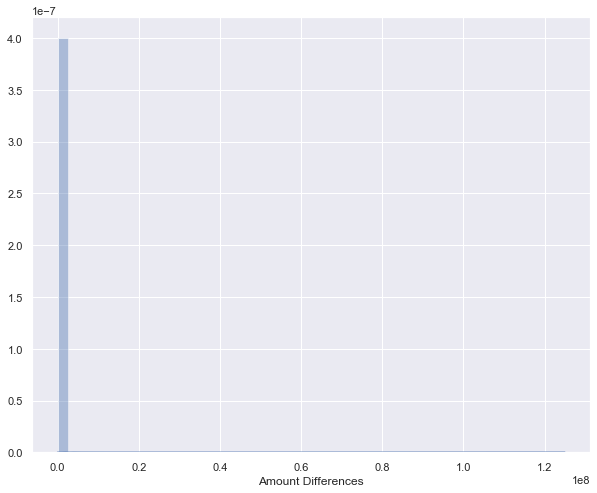

In [36]:
plt.figure(figsize=(10,8))
sns.distplot(tsa_amount_nona['Amount Differences'])

There is seems a differences in number that was way far. This time, lets use the Interquartile range (IQR) method to find the datapoint that seems to be an outlier based on the Amount Differences column, show the dataframe, and lets describe the Claim Amount and Close Amount column of the outlier dataframe based on the Amount Differences column

In [37]:
Q1=tsa_amount_nona.describe()['Amount Differences']['25%']
Q3=tsa_amount_nona.describe()['Amount Differences']['75%']
IQR=Q3-Q1
bawah=Q1-(1.5*IQR)
atas=Q3+(1.5*IQR)

In [38]:
tsa_outlier=tsa_amount_nona[(tsa_amount_nona['Amount Differences']>bawah) & (tsa_amount_nona['Amount Differences']>atas)]
tsa_outlier

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,Day Differences,Amount Differences
4,17846,2002-09-09,2002-08-30 00:00:00,BOS,Boston (Logan) International Airport,NaN,Property Damage,Checkpoint,Luggage (all types including footlockers),1832.22,Canceled,0.00,NaN,10.0,1832.22
13,19133,2002-10-02,2002-08-22 00:00:00,CLE,Cleveland Hopkins International,Northwest Airlines,NaN,Other,Computer - Laptop,2000.00,Denied,0.00,Deny,41.0,2000.00
21,18614,2002-10-17,2002-09-14 00:00:00,MCO,Orlando International Airport,American Airlines,Property Damage,Checkpoint,Computer - Laptop,2000.00,Settled,600.00,Settle,33.0,1400.00
23,18356,2002-10-23,2002-09-18 00:00:00,LGA,LaGuardia,NaN,NaN,Checkpoint,Computer - Laptop,1801.99,Settled,291.67,Settle,35.0,1510.32
27,21817,2002-10-29,2002-10-05 00:00:00,MCO,Orlando International Airport,Delta Air Lines,NaN,Other,Other,7500.00,Denied,0.00,Deny,24.0,7500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36208,2009123167012,2009-12-29,2009-12-18 00:00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checked Baggage,NaN,2200.00,Denied,0.00,Deny,11.0,2200.00
36210,2009123167017,2009-12-29,2009-12-02 15:30:00,JFK,John F. Kennedy International,KLM Royal Dutch Airlines,Passenger Property Loss,Checked Baggage,Clothing - Shoes; belts; accessories; etc.; Co...,900.00,Denied,0.00,Deny,26.0,900.00
36213,2010010867323,2009-12-29,2009-12-21 15:15:00,CVG,Cincinnati/Northern Kentucky International,Delta Air Lines,Property Damage,Checkpoint,Computer - Laptop,1240.00,Denied,0.00,Deny,7.0,1240.00
36225,2009123066912,2009-12-30,2009-12-15 00:00:00,GSO,Piedmont Triad International Airport,Delta Air Lines,Property Damage,Checked Baggage,NaN,2300.00,Denied,0.00,Deny,15.0,2300.00


In [39]:
tsa_outlier['Claim Amount'].describe()

count    4.103000e+03
mean     4.164579e+04
std      1.954354e+06
min      8.510100e+02
25%      1.214375e+03
50%      1.821750e+03
75%      3.000000e+03
max      1.250000e+08
Name: Claim Amount, dtype: float64

In [40]:
tsa_outlier['Close Amount'].describe()

count     4103.000000
mean       114.613646
std        686.521806
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      20000.000000
Name: Close Amount, dtype: float64

It seems that Claim Amount feature really affecting lot of the differences that happen as 75% outlier data that in the Close Amount feature is still 0.

In [41]:
tsa_no_outlier=tsa_amount_nona[(tsa_amount_nona['Amount Differences']>bawah) & (tsa_amount_nona['Amount Differences']<atas)]
print(tsa_no_outlier['Claim Amount'].describe())
tsa_outlier['Claim Amount'].describe()

count     29340.000000
mean        244.320358
std        1563.219050
min           0.000000
25%          52.977500
50%         139.925000
75%         300.000000
max      250000.000000
Name: Claim Amount, dtype: float64


count    4.103000e+03
mean     4.164579e+04
std      1.954354e+06
min      8.510100e+02
25%      1.214375e+03
50%      1.821750e+03
75%      3.000000e+03
max      1.250000e+08
Name: Claim Amount, dtype: float64

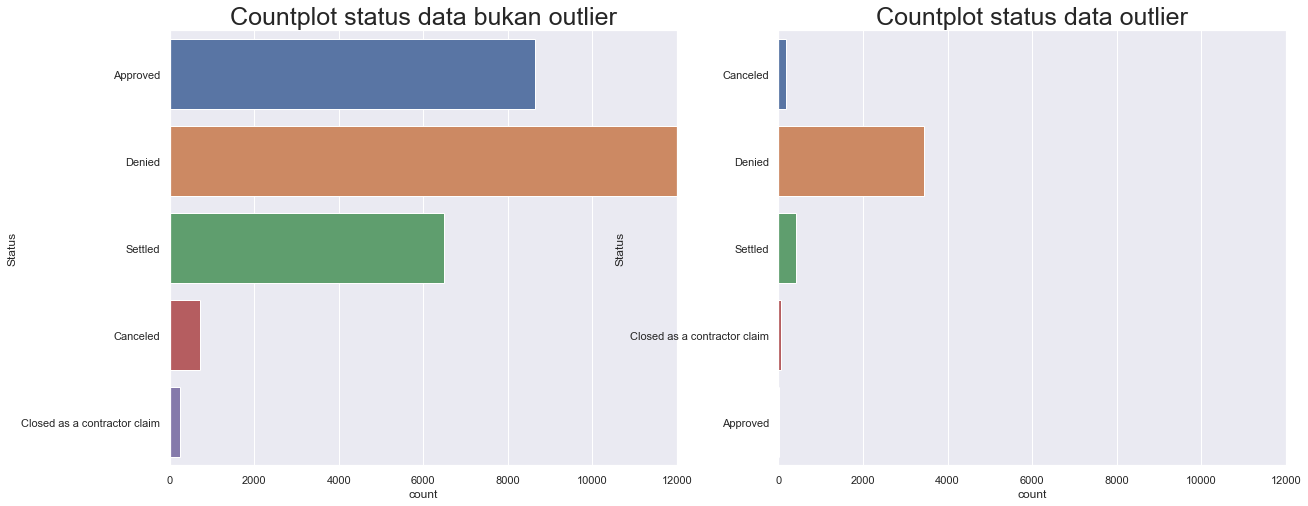

In [48]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Countplot status data bukan outlier', fontsize=25)
plt.xlim(0,12000)
sns.countplot(y=tsa_no_outlier['Status'])
plt.subplot(1,2,2)
plt.title('Countplot status data outlier', fontsize=25)
plt.xlim(0,12000)
sns.countplot(y=tsa_outlier['Status'])

In [44]:
tsa_outlier[tsa_outlier['Status']=='Denied']['Close Amount'].value_counts()

0.0    3450
Name: Close Amount, dtype: int64

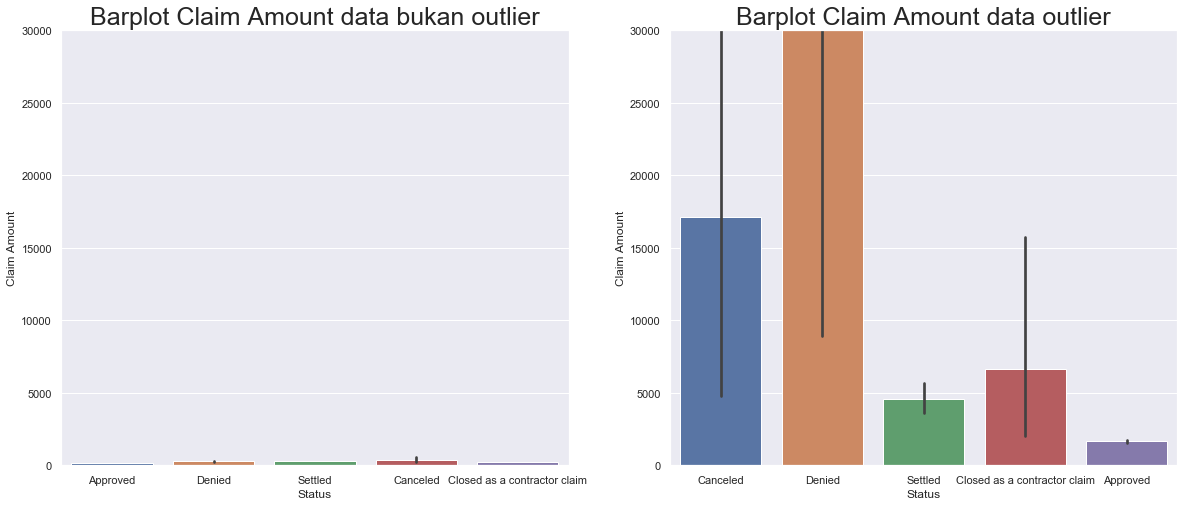

In [51]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Barplot Claim Amount data bukan outlier', fontsize=25)
plt.ylim(0,30000)
sns.barplot(data=tsa_no_outlier, x='Status', y='Claim Amount')
plt.subplot(1,2,2)
plt.title('Barplot Claim Amount data outlier', fontsize=25)
plt.ylim(0,30000)
sns.barplot(data=tsa_outlier, x='Status', y='Claim Amount')

Jika kita deskripsikan data claim amount yang ada pada outlier dan non outlier, kita dapat melihat perbedaan yang cukup jauh dimana nilai claim amount pada data outlier lebih besar dari data nonoutlier. Hal ini ditunjukkan pada barplot untuk claim amount pada data outlier dan bukan outlier, dimana claim amount yang ada pada data outlier dan bukan outlier berbeda sangat signifikan.

Pada countplot diatas ditunjukkan jumlah-jumlah status yang merupakan data outlier, Sekitar 84% status dari claim tersebut ditolak. Hal ini menyebabkan close amountnya bernilai 0, sehingga menyebabkan amount differences yang sangat besar dan menjadikan amount differences ini outlier. Berbeda dengan data yang tidak outlier, meskipun secara countplot memang status denied pada data yang non outlier lebih banyak. Tapi, Claim Amount yang ada pada data outlier lebih besar daripada data non outlier.

## Analysis

We have try to cleaning some of the data that we have, and now we could try to done few analysis from the data we had.=

In [119]:
tsa

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,Day Differences,Amount Differences
0,0909816M,2002-02-07,2003-01-06,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.0,Approve in Full,-333.0,0.00
1,14268,2002-06-20,2002-06-16,PHX,Phoenix Sky Harbor International,NaN,Property Damage,Checkpoint,Computer - Laptop,2270.09,Canceled,NaN,NaN,4.0,NaN
2,15242,2002-07-12,2002-05-31,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Other,Luggage (all types including footlockers),200.00,Denied,0.0,Deny,42.0,200.00
3,16759,2002-08-21,2002-07-12,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,Passenger Property Loss,Checkpoint,Other,21.44,Approved,21.0,Approve in Full,40.0,0.44
4,17846,2002-09-09,2002-08-30,BOS,Boston (Logan) International Airport,NaN,Property Damage,Checkpoint,Luggage (all types including footlockers),1832.22,Canceled,0.0,NaN,10.0,1832.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51061,2015110926685,2015-10-22,2015-10-19,NaN,NaN,NaN,Property Damage,Checked Baggage,Baggage/Cases/Purses,NaN,NaN,NaN,NaN,3.0,NaN
51062,2015110226479,2015-11-02,2015-11-02,NaN,NaN,NaN,Passenger Property Loss,Checkpoint,Books; Magazines & Other,NaN,NaN,NaN,NaN,0.0,NaN
51063,2015120727336,2015-11-16,2015-09-14,NaN,NaN,American Airlines,Passenger Property Loss,Checked Baggage,Cosmetics & Grooming,NaN,NaN,NaN,NaN,63.0,NaN
51064,2015120427297,2015-11-20,2015-10-16,NaN,NaN,NaN,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,NaN,NaN,NaN,NaN,35.0,NaN


In [116]:
print('Jumlah data yang memiliki nilai Nan pada Airport dan Airline')
print(len(tsa[tsa['Airport Code'].isna() & tsa['Airline Name'].isna()]))
tsa[(tsa['Airport Name'].isna()) & (tsa['Airline Name'].isna())]['Status'].value_counts()

Jumlah data yang memiliki nilai Nan pada Airport dan Airline
1598


Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.    635
Canceled                                                                                                                         267
Denied                                                                                                                           207
Settled                                                                                                                          203
Approved                                                                                                                         200
Closed as a contractor claim                                                                                                       5
Claim entered                                                                                                                      2
Name: Status, dtype: int64

In [74]:
klaim=tsa[tsa['Claim Type'].isna()]
klaim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 2 to 51059
Data columns (total 15 columns):
Claim Number          2031 non-null object
Date Received         1996 non-null datetime64[ns]
Incident Date         1649 non-null datetime64[ns]
Airport Code          1484 non-null object
Airport Name          1484 non-null object
Airline Name          1028 non-null object
Claim Type            0 non-null object
Claim Site            1901 non-null object
Item                  1877 non-null object
Claim Amount          1558 non-null float64
Status                1979 non-null object
Close Amount          1535 non-null float64
Disposition           1460 non-null object
Day Differences       1647 non-null float64
Amount Differences    1343 non-null float64
dtypes: datetime64[ns](2), float64(4), object(9)
memory usage: 253.9+ KB


In [75]:
for i in klaim.columns:
    print(i)
    print(tsa[tsa['Claim Type'].isna()][i].value_counts())
    print('\n')

Claim Number
1022330M         1
0710014M         1
1217361M         1
0223064M         1
1217481M         1
                ..
1222122M         1
2013020701154    1
0114180M         1
0210320M         1
0226574M         1
Name: Claim Number, Length: 2031, dtype: int64


Date Received
2004-01-14    44
2004-02-02    40
2004-03-05    40
2003-11-17    39
2003-12-05    39
              ..
2005-04-05     1
2004-12-22     1
2003-06-30     1
2011-06-27     1
2009-09-01     1
Name: Date Received, Length: 485, dtype: int64


Incident Date
2004-01-15    11
2003-12-27    11
2004-10-09    10
2004-01-05     9
2003-12-30     8
              ..
2004-11-22     1
2010-01-02     1
2002-10-25     1
2004-09-08     1
2002-09-11     1
Name: Incident Date, Length: 783, dtype: int64


Airport Code
LAX    100
EWR     71
MIA     65
ORD     60
JFK     53
      ... 
SHV      1
ACT      1
TOL      1
OKC      1
ABR      1
Name: Airport Code, Length: 151, dtype: int64


Airport Name
Los Angeles International Airport 

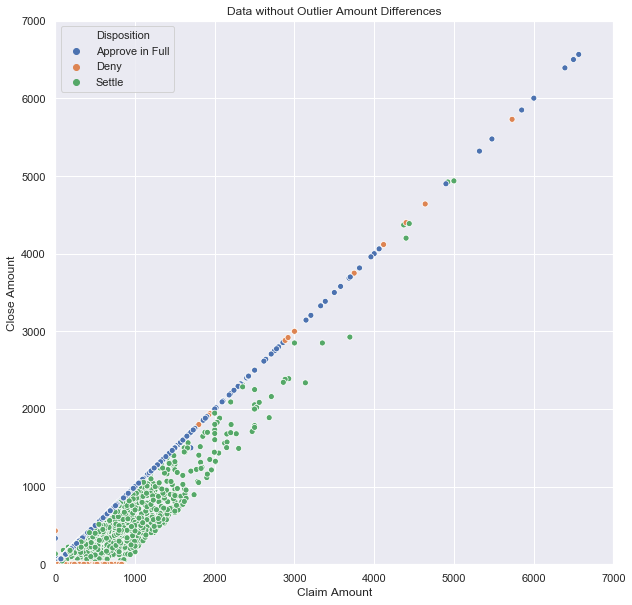

In [158]:
plt.figure(figsize=(10,10))
plt.xlim(0,7000)
plt.ylim(0,7000)
plt.title('Data without Outlier Amount Differences')
sns.scatterplot(data=tsa_no_outlier, x='Claim Amount', y='Close Amount', hue='Disposition')

1.
Tidak ada hubungan yang signifikan yang ada pada kolom airport code atau nama airport. Namun saya menemukan data yang tidak memiliki nama airport ataupun airline, sekitar 39% datanya memiliki status Insufficient yang dikarenakan kurang lengkapnya data yang diperoleh. Kemungkinan data-data yang nama 

airport atau airline nan dikarenakan insufficient status.
Untuk Claim type yang nilainya null tidak ada hal yang signifikan yang menyebabkan claim type null, Kemungkinan insufficient status yang diperoleh cukup banyak. 25.54% data dari claim type yang null memiliki Denied disposition.

2.
Pada kolom status ketika status menunjukkan Denied, Kolom pada disposition akan menjadi deny dan kolom close amount bernilai 0 atau nan. Hal ini dikarenakan ketika ditolak klaimnya, tidak ada jumlah dibayarkan pihak airport sehingga isinya 0 atau nan. Namun ketika klaim diaproved keseluruhan maka kolom disposition akan menjadi aproved full dan nilai close amount akan sama dengan claim amount, jika tidak sepenuhnya diklaim kolom disposition akan menjadi settle dan nilai close amount kurang dari claim amount. Hal ini dapat dilihat dari scatter plot diatas, ketika disposition diaproved nilai claim amount dan close amount bernilai sama. Berbeda dengan disposition denied close amountnya akan jatuh ke 0 seiring meningkatnya claim amountnya.

In [192]:
tsa_no_outlier['Status'].value_counts()

Denied                          13245
Approved                         8631
Settled                          6500
Canceled                          719
Closed as a contractor claim      245
Name: Status, dtype: int64

In [175]:
tolak=tsa_no_outlier[(tsa_no_outlier['Status']=='Denied') | (tsa_no_outlier['Status']=='Canceled') | (tsa_no_outlier['Status']=='Closed as a contractor claim')]
selaintolak=tsa_no_outlier[(tsa_no_outlier['Status']=='Approved') | (tsa_no_outlier['Status']=='Settled')]

In [176]:
print(try_normal(selaintolak['Claim Amount']))
print(try_normal(tolak['Claim Amount']))

{'Anderson': {15.0: 0.576, 10.0: 0.656, 5.0: 0.787, 2.5: 0.918, 1.0: 1.092, 'stat': 1923.7497969491633}, 'Shapiro': 0.0, 'K^2': 0.0}
{'Anderson': {15.0: 0.576, 10.0: 0.656, 5.0: 0.787, 2.5: 0.918, 1.0: 1.092, 'stat': 4385.422448310612}, 'Shapiro': 0.0, 'K^2': 0.0}


In [169]:
kruskal(tolak['Claim Amount'],selaintolak['Claim Amount'])

KruskalResult(statistic=620.1852885138279, pvalue=6.814870174477721e-137)

Melalui test diatas dapat dikatakan dengan tingkat kepercayaan 95%, bahwa terdapat perbedaan antara claim yang diajukan dengan status ditolak atau cancel dengan claim yang dibayarkan full atau beberapa